In [59]:
import polars as pl
import numpy as np
from datetime import datetime,timedelta
import random

# Pytorch for ML

import torch
import torch.nn as nn
import torch.optim as optim
import research

#visualization
import altair as alt

#data
import binance

import importlib
importlib.reload(research)
importlib.reload(binance)

<module 'binance' from '/Users/ujjawalpratapsingh/Documents/quant-strategy/binance.py'>

In [2]:
research.set_seed(42)

In [3]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)

polars.config.Config

In [4]:
sym = 'BTCUSDT'

hist_data_window = 7 * 4 * 6

time_interval = '1h'

max_lags = 4

forecast_horizon = 1

annualized_rate = research.sharpe_annualization_factor(time_interval, 365,24)

In [5]:
binance.download_trades(sym,hist_data_window)

downloading BTCUSDT: 100%|██████████| 168/168 [00:04<00:00, 34.75it/s]

[ERROR] BTCUSDT 2025-11-02: 404 Client Error: Not Found for url: https://data.binance.vision/data/futures/um/daily/trades/BTCUSDT/BTCUSDT-trades-2025-11-02.zip


In [6]:
ts = research.load_ohlc_timeseries(sym,time_interval)
ts

Loading BTCUSDT: 100%|██████████| 403/403 [00:25<00:00, 16.07file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-09-25 00:00:00,64243.2,64410.0,63955.9,64090.1
2024-09-25 01:00:00,64090.2,64800.0,64051.7,64355.0
2024-09-25 02:00:00,64355.1,64533.0,64253.4,64390.0
2024-09-25 03:00:00,64390.0,64433.3,64191.8,64422.4
2024-09-25 04:00:00,64422.5,64430.0,64140.0,64142.3
…,…,…,…,…
2025-11-01 19:00:00,110294.9,110294.9,110171.7,110249.0
2025-11-01 20:00:00,110249.0,110487.0,110248.9,110358.4
2025-11-01 21:00:00,110358.4,110389.9,109803.5,109815.2


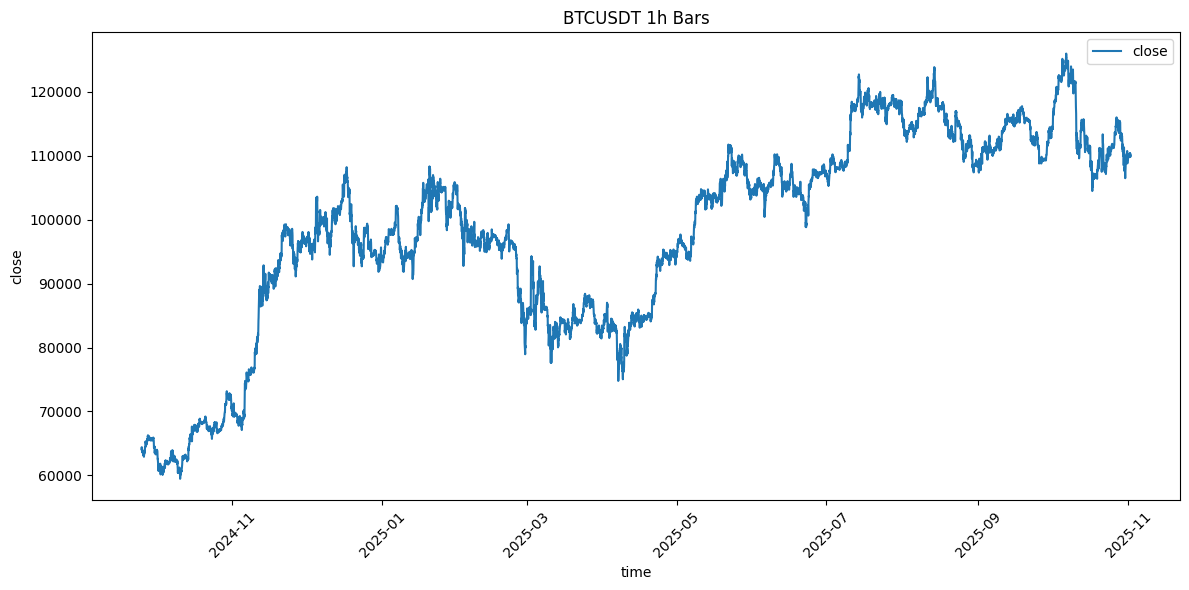

In [7]:
research.plot_static_timeseries(ts,sym,'close',time_interval)

In [8]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym,'close',time_interval)

alt.Chart(...)

In [9]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))

In [10]:
target = 'close_log_return'
ts = research.add_lags(ts, target, max_lags,forecast_horizon)

In [11]:
ts = ts.drop_nulls()

In [12]:
research.plot_distribution(ts, target, no_bins = 200)

alt.Chart(...)

In [13]:
research.plot_distribution(ts, 'close', no_bins = 200)

alt.Chart(...)

In [14]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel,self).__init__()
        self.linear = nn.Linear(input_features,1)

    def forward(self,x):
        return self.linear(x)

In [15]:
input_features = 1

linear_model = LinearModel(input_features)

In [16]:
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [17]:
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-25 05:00:00,64142.2,64254.1,64108.4,64140.0,-0.000036,-0.004357,0.000503,0.000544,0.004125
2024-09-25 06:00:00,64140.0,64140.0,63713.3,63776.6,-0.005682,-0.000036,-0.004357,0.000503,0.000544
2024-09-25 07:00:00,63776.5,63838.1,63612.3,63814.9,0.0006,-0.005682,-0.000036,-0.004357,0.000503
2024-09-25 08:00:00,63814.9,63888.3,63726.4,63795.2,-0.000309,0.0006,-0.005682,-0.000036,-0.004357
2024-09-25 09:00:00,63795.2,63844.0,63579.0,63588.0,-0.003253,-0.000309,0.0006,-0.005682,-0.000036
…,…,…,…,…,…,…,…,…,…
2025-11-01 19:00:00,110294.9,110294.9,110171.7,110249.0,-0.000416,0.001223,-0.002299,0.001455,0.003391
2025-11-01 20:00:00,110249.0,110487.0,110248.9,110358.4,0.000992,-0.000416,0.001223,-0.002299,0.001455
2025-11-01 21:00:00,110358.4,110389.9,109803.5,109815.2,-0.004934,0.000992,-0.000416,0.001223,-0.002299


In [18]:
X_train,X_test,y_train,y_test = research.timeseries_train_test_split(ts,features,target,test_size)

In [19]:
no_epochs = 1000 * 5
lr = 0.0005

model = LinearModel(len(features))

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr = lr)

print("\n Training Model .....")

for epoch in range(no_epochs):
    y_hat = model(X_train)
    loss = criterion(y_hat,y_train)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss = loss.item()

    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1/no_epochs}], Loss: {train_loss: .6f}")

print("\n Learned Parameters")

for name,param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: \n{param.data.numpy()}")

model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat,y_test)
    print(f"\n Test Loss : {test_loss.item():.6f}, Train Loss : {train_loss:.6f}")


 Training Model .....
Epoch [499.0002], Loss:  0.468820
Epoch [999.0002], Loss:  0.234593
Epoch [1499.0002], Loss:  0.101727
Epoch [1999.0002], Loss:  0.036154
Epoch [2499.0002], Loss:  0.009765
Epoch [2999.0002], Loss:  0.001830
Epoch [3499.0002], Loss:  0.000231
Epoch [3999.0002], Loss:  0.000039
Epoch [4499.0002], Loss:  0.000027
Epoch [4999.0002], Loss:  0.000027

 Learned Parameters
linear.weight: 
[[-0.07889079]]
linear.bias: 
[0.0001393]

 Test Loss : 0.000014, Train Loss : 0.000027


### Test Trading performance

In [20]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y' :y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign() == pl.col('y').sign()).alias('is_win'),
    pl.col('y_hat').sign().alias('signal')
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)

In [21]:
trade_results

y_hat,y,is_win,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000232,0.008056,true,1.0,0.008056,0.008056
-0.000496,0.003208,false,-1.0,-0.003208,0.004848
-0.000114,-0.002429,true,-1.0,0.002429,0.007277
0.000331,-0.000931,false,1.0,-0.000931,0.006346
0.000213,0.001756,true,1.0,0.001756,0.008102
…,…,…,…,…,…
0.000043,-0.000416,false,1.0,-0.000416,0.001041
0.000172,0.000992,true,1.0,0.000992,0.002033
0.000061,-0.004934,false,1.0,-0.004934,-0.002901


In [22]:
research.plot_column(trade_results,'equity_curve')

alt.Chart(...)

In [23]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve') - pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_win,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000232,0.008056,true,1.0,0.008056,0.008056,0.0
-0.000496,0.003208,false,-1.0,-0.003208,0.004848,-0.003208
-0.000114,-0.002429,true,-1.0,0.002429,0.007277,-0.000779
0.000331,-0.000931,false,1.0,-0.000931,0.006346,-0.001709
0.000213,0.001756,true,1.0,0.001756,0.008102,0.0
…,…,…,…,…,…,…
0.000043,-0.000416,false,1.0,-0.000416,0.001041,-0.192685
0.000172,0.000992,true,1.0,0.000992,0.002033,-0.191693
0.000061,-0.004934,false,1.0,-0.004934,-0.002901,-0.196627


In [24]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.2640308737754822

In [25]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.2320501702199248)

In [26]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-232.0501702199248)

In [27]:
win_rate = trade_results['is_win'].mean()
win_rate

0.4997931319817956

In [28]:
avg_win = trade_results.filter(pl.col('is_win') == True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_win') == False)['trade_log_return'].mean()

In [29]:
ev = win_rate * avg_win + (1- win_rate) * avg_loss
ev

-3.5121398224207886e-07

In [30]:
total_log_return = trade_results["trade_log_return"].sum()
total_log_return

-0.0008488772436976433

In [31]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(0.9991514829506624)

In [32]:
equity_trough = trade_results["equity_curve"].min()
equity_trough

-0.07030466198921204

In [33]:
equity_peak = trade_results["equity_curve"].max()
equity_peak

0.19372619688510895

In [34]:
std = trade_results["equity_curve"].std()
std

0.061521224677562714

In [35]:
sharpe = ev/std * annualized_rate
sharpe


np.float64(-0.0005343168599691408)

In [36]:
research.eval_model_performance(y_test,y_hat,features,target,annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'num_trades': 2417,
 'win_rate': 0.4997931319817956,
 'avg_loss': -0.002474346457300548,
 'avg_win': 0.0024756920386434463,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.02237566001713276,
 'ev': -3.5121398224207886e-07,
 'std': 0.061521224677562714,
 'total_log_return': -0.0008488772436976433,
 'compound_return': np.float64(0.9991514829506624),
 'max_drawdown': -0.2640308737754822,
 'equity_trough': -0.07030466198921204,
 'equity_peak': 0.19372619688510895,
 'sharpe': np.float64(-0.008932144581573513)}

In [47]:
target = 'close_log_return'
features = ['close_log_return_lag_3']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target,model, annualized_rate, num_epochs = 200)
perf

100%|██████████| 200/200 [00:07<00:00, 26.98it/s]


{'features': 'close_log_return_lag_3',
 'target': 'close_log_return',
 'num_trades': 2417,
 'win_rate': 0.49648324369052543,
 'avg_loss': -0.0024843690467742244,
 'avg_win': 0.0024655364330278453,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.02237566001713276,
 'ev': -2.682391820058613e-05,
 'std': 0.03553711622953415,
 'total_log_return': -0.06483341753482819,
 'compound_return': np.float64(0.9372235753878859),
 'max_drawdown': -0.18710339069366455,
 'equity_trough': -0.11667528748512268,
 'equity_peak': 0.07042809575796127,
 'sharpe': np.float64(-0.6822094061576693),
 'weight': '[-2.6572234e-05]',
 'biases': '7.756642298772931e-05'}

In [40]:
import itertools

benchmark = []
feature_pool = [f'{target}_lag_{i}' for i in range(1,max_lags+1)]

combos = list(itertools.combinations(feature_pool,1))

for feature in combos:
    model = LinearModel(len(feature))
    benchmark.append(research.benchmark_reg_model(ts, list(feature), target, model, annualized_rate, num_epochs = 200, loss = nn.L1Loss()))

benchmark = pl.DataFrame(benchmark)
benchmark.sort('sharpe', descending = True)

('close_log_return_lag_1',)


100%|██████████| 200/200 [00:07<00:00, 26.52it/s]


[{'features': 'close_log_return_lag_1', 'target': 'close_log_return', 'num_trades': 2417, 'win_rate': 0.49648324369052543, 'avg_loss': -0.0024843690467742244, 'avg_win': 0.0024655364330278453, 'best_trade': 0.03395244851708412, 'worst_trade': -0.02237566001713276, 'ev': -2.682391820058613e-05, 'std': 0.03553711622953415, 'total_log_return': -0.06483341753482819, 'compound_return': np.float64(0.9372235753878859), 'max_drawdown': -0.18710339069366455, 'equity_trough': -0.11667528748512268, 'equity_peak': 0.07042809575796127, 'sharpe': np.float64(-0.6822094061576693), 'weight': '[0.00025639]', 'biases': '7.771074888296425e-05'}]
('close_log_return_lag_2',)


100%|██████████| 200/200 [00:07<00:00, 27.48it/s]


[{'features': 'close_log_return_lag_1', 'target': 'close_log_return', 'num_trades': 2417, 'win_rate': 0.49648324369052543, 'avg_loss': -0.0024843690467742244, 'avg_win': 0.0024655364330278453, 'best_trade': 0.03395244851708412, 'worst_trade': -0.02237566001713276, 'ev': -2.682391820058613e-05, 'std': 0.03553711622953415, 'total_log_return': -0.06483341753482819, 'compound_return': np.float64(0.9372235753878859), 'max_drawdown': -0.18710339069366455, 'equity_trough': -0.11667528748512268, 'equity_peak': 0.07042809575796127, 'sharpe': np.float64(-0.6822094061576693), 'weight': '[0.00025639]', 'biases': '7.771074888296425e-05'}, {'features': 'close_log_return_lag_2', 'target': 'close_log_return', 'num_trades': 2417, 'win_rate': 0.49648324369052543, 'avg_loss': -0.0024843690467742244, 'avg_win': 0.0024655364330278453, 'best_trade': 0.03395244851708412, 'worst_trade': -0.02237566001713276, 'ev': -2.682391820058613e-05, 'std': 0.03553711622953415, 'total_log_return': -0.06483341753482819, 'c

100%|██████████| 200/200 [00:07<00:00, 26.53it/s]


[{'features': 'close_log_return_lag_1', 'target': 'close_log_return', 'num_trades': 2417, 'win_rate': 0.49648324369052543, 'avg_loss': -0.0024843690467742244, 'avg_win': 0.0024655364330278453, 'best_trade': 0.03395244851708412, 'worst_trade': -0.02237566001713276, 'ev': -2.682391820058613e-05, 'std': 0.03553711622953415, 'total_log_return': -0.06483341753482819, 'compound_return': np.float64(0.9372235753878859), 'max_drawdown': -0.18710339069366455, 'equity_trough': -0.11667528748512268, 'equity_peak': 0.07042809575796127, 'sharpe': np.float64(-0.6822094061576693), 'weight': '[0.00025639]', 'biases': '7.771074888296425e-05'}, {'features': 'close_log_return_lag_2', 'target': 'close_log_return', 'num_trades': 2417, 'win_rate': 0.49648324369052543, 'avg_loss': -0.0024843690467742244, 'avg_win': 0.0024655364330278453, 'best_trade': 0.03395244851708412, 'worst_trade': -0.02237566001713276, 'ev': -2.682391820058613e-05, 'std': 0.03553711622953415, 'total_log_return': -0.06483341753482819, 'c

100%|██████████| 200/200 [00:07<00:00, 26.98it/s]

[{'features': 'close_log_return_lag_1', 'target': 'close_log_return', 'num_trades': 2417, 'win_rate': 0.49648324369052543, 'avg_loss': -0.0024843690467742244, 'avg_win': 0.0024655364330278453, 'best_trade': 0.03395244851708412, 'worst_trade': -0.02237566001713276, 'ev': -2.682391820058613e-05, 'std': 0.03553711622953415, 'total_log_return': -0.06483341753482819, 'compound_return': np.float64(0.9372235753878859), 'max_drawdown': -0.18710339069366455, 'equity_trough': -0.11667528748512268, 'equity_peak': 0.07042809575796127, 'sharpe': np.float64(-0.6822094061576693), 'weight': '[0.00025639]', 'biases': '7.771074888296425e-05'}, {'features': 'close_log_return_lag_2', 'target': 'close_log_return', 'num_trades': 2417, 'win_rate': 0.49648324369052543, 'avg_loss': -0.0024843690467742244, 'avg_win': 0.0024655364330278453, 'best_trade': 0.03395244851708412, 'worst_trade': -0.02237566001713276, 'ev': -2.682391820058613e-05, 'std': 0.03553711622953415, 'total_log_return': -0.06483341753482819, 'c

features,target,num_trades,win_rate,avg_loss,avg_win,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weight,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",2417,0.496483,-0.002484,0.002466,0.033952,-0.022376,-0.000027,0.035537,-0.064833,0.937224,-0.187103,-0.116675,0.070428,-0.682209,"""[0.00025639]""","""7.771074888296425e-05"""
"""close_log_return_lag_2""","""close_log_return""",2417,0.496483,-0.002484,0.002466,0.033952,-0.022376,-0.000027,0.035537,-0.064833,0.937224,-0.187103,-0.116675,0.070428,-0.682209,"""[-5.4682372e-05]""","""7.763165194774047e-05"""
"""close_log_return_lag_3""","""close_log_return""",2417,0.496483,-0.002484,0.002466,0.033952,-0.022376,-0.000027,0.035537,-0.064833,0.937224,-0.187103,-0.116675,0.070428,-0.682209,"""[6.381096e-05]""","""7.98550681793131e-05"""
"""close_log_return_lag_4""","""close_log_return""",2417,0.496483,-0.002484,0.002466,0.033952,-0.022376,-0.000027,0.035537,-0.064833,0.937224,-0.187103,-0.116675,0.070428,-0.682209,"""[-5.6266435e-05]""","""7.82858332968317e-05"""


In [44]:
research.auto_reg_corr_matrx(ts,target,max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.025917,0.003489,-0.022468,0.013525
-0.025917,1.0,-0.025925,0.003479,-0.022546
0.003489,-0.025925,1.0,-0.025881,0.003479
-0.022468,0.003479,-0.025881,1.0,-0.025852
0.013525,-0.022546,0.003479,-0.025852,1.0


In [45]:
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-25 05:00:00,64142.2,64254.1,64108.4,64140.0,-0.000036,-0.004357,0.000503,0.000544,0.004125
2024-09-25 06:00:00,64140.0,64140.0,63713.3,63776.6,-0.005682,-0.000036,-0.004357,0.000503,0.000544
2024-09-25 07:00:00,63776.5,63838.1,63612.3,63814.9,0.0006,-0.005682,-0.000036,-0.004357,0.000503
2024-09-25 08:00:00,63814.9,63888.3,63726.4,63795.2,-0.000309,0.0006,-0.005682,-0.000036,-0.004357
2024-09-25 09:00:00,63795.2,63844.0,63579.0,63588.0,-0.003253,-0.000309,0.0006,-0.005682,-0.000036
…,…,…,…,…,…,…,…,…,…
2025-11-01 19:00:00,110294.9,110294.9,110171.7,110249.0,-0.000416,0.001223,-0.002299,0.001455,0.003391
2025-11-01 20:00:00,110249.0,110487.0,110248.9,110358.4,0.000992,-0.000416,0.001223,-0.002299,0.001455
2025-11-01 21:00:00,110358.4,110389.9,109803.5,109815.2,-0.004934,0.000992,-0.000416,0.001223,-0.002299


In [50]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model,num_epochs = 200, loss = nn.L1Loss())

research.plot_column(model_trades,'equity_curve')

  0%|          | 0/200 [00:00<?, ?it/s]/Users/ujjawalpratapsingh/Documents/quant-strategy/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:129: UserWarning: Using a target size (torch.Size([7250])) that is different to the input size (torch.Size([7250, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 200/200 [00:07<00:00, 27.64it/s]
/Users/ujjawalpratapsingh/Documents/quant-strategy/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:129: UserWarning: Using a target size (torch.Size([2417])) that is different to the input size (torch.Size([2417, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


alt.Chart(...)

#### Add Transaction fees

In [55]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1-2 * maker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')). alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
model_trades

y_pred,y_true,is_win,signal,trade_log_return,equity_curve,drawdown_log,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f64,f32,f32,f64,f64,f64
0.000076,0.008056,true,1.0,0.006855,0.008056,0.0,-0.0002,0.006655,0.006655
0.000076,0.003208,true,1.0,0.002007,0.011263,0.0,-0.0002,0.001807,0.008463
0.000076,-0.002429,false,1.0,-0.003629,0.008834,-0.002429,-0.0002,-0.003829,0.004633
0.000076,-0.000931,false,1.0,-0.002131,0.007904,-0.00336,-0.0002,-0.002331,0.002302
0.000076,0.001756,true,1.0,0.000556,0.00966,-0.001604,-0.0002,0.000356,0.002658
…,…,…,…,…,…,…,…,…,…
0.000076,-0.000416,false,1.0,-0.001617,-0.063001,-0.133429,-0.0002,-0.001817,-3.442119
0.000076,0.000992,true,1.0,-0.000209,-0.062009,-0.132438,-0.0002,-0.000409,-3.442527
0.000076,-0.004934,false,1.0,-0.006135,-0.066944,-0.137372,-0.0002,-0.006335,-3.448862


In [56]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [60]:
model_trades = research.add_tx_fees(model_trades, maker_fee,taker_fee)
model_trades


y_pred,y_true,is_win,signal,trade_log_return,equity_curve,drawdown_log,tx_fee_log,trade_log_return_net,equity_curve_net,tx_fee_log_maker,trade_log_return_net_maker,equity_curve_net_maker,tx_fee_log_taker,trade_log_return_net_taker,equity_curve_net_taker
f32,f32,bool,f32,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000076,0.008056,true,1.0,0.006855,0.008056,0.0,-0.0002,0.006655,0.006655,-0.0002,0.006655,0.006655,-0.0006,0.006255,0.006255
0.000076,0.003208,true,1.0,0.002007,0.011263,0.0,-0.0002,0.001807,0.008463,-0.0002,0.001807,0.008463,-0.0006,0.001407,0.007662
0.000076,-0.002429,false,1.0,-0.003629,0.008834,-0.002429,-0.0002,-0.003829,0.004633,-0.0002,-0.003829,0.004633,-0.0006,-0.00423,0.003433
0.000076,-0.000931,false,1.0,-0.002131,0.007904,-0.00336,-0.0002,-0.002331,0.002302,-0.0002,-0.002331,0.002302,-0.0006,-0.002731,0.000701
0.000076,0.001756,true,1.0,0.000556,0.00966,-0.001604,-0.0002,0.000356,0.002658,-0.0002,0.000356,0.002658,-0.0006,-0.000045,0.000657
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000076,-0.000416,false,1.0,-0.001617,-0.063001,-0.133429,-0.0002,-0.001817,-3.442119,-0.0002,-0.001817,-3.442119,-0.0006,-0.002217,-4.407705
0.000076,0.000992,true,1.0,-0.000209,-0.062009,-0.132438,-0.0002,-0.000409,-3.442527,-0.0002,-0.000409,-3.442527,-0.0006,-0.000809,-4.408514
0.000076,-0.004934,false,1.0,-0.006135,-0.066944,-0.137372,-0.0002,-0.006335,-3.448862,-0.0002,-0.006335,-3.448862,-0.0006,-0.006735,-4.415248
